# NeurIPS_Open-Polymer-Prediction-2025

### Goal 


### Data


Refer `TOX - EDA.ipynb` for EDA

### QSPR Models 

In [1]:
#import
import numpy as np
import pandas as pd
from rdkit import Chem
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, DataStructs

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score

## XGBOOST - Descriptors

In [2]:
def generate_2d_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return {desc_name: func(mol) for desc_name, func in Descriptors.descList}

In [3]:
def generate_3d_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None 
    mol = Chem.AddHs(mol)  

    try:
        AllChem.EmbedMolecule(mol, AllChem.ETKDG())
        AllChem.UFFOptimizeMolecule(mol)

        descriptors_3d = {
            "radius_of_gyration": rdMolDescriptors.CalcRadiusOfGyration(mol),
            "asphericity": rdMolDescriptors.CalcAsphericity(mol),
            "spherocity_index": rdMolDescriptors.CalcSpherocityIndex(mol),
            "eccentricity": rdMolDescriptors.CalcEccentricity(mol),
            "NPR1": rdMolDescriptors.CalcNPR1(mol),
            "NPR2": rdMolDescriptors.CalcNPR2(mol),
            "PMI1": rdMolDescriptors.CalcPMI1(mol),
            "PMI2": rdMolDescriptors.CalcPMI2(mol),
            "PMI3": rdMolDescriptors.CalcPMI3(mol),
        }

        return descriptors_3d

    except:
        return None 

In [4]:
data = pd.read_csv("train.csv")

In [5]:
#Rg
datafile = data[['SMILES','FFV']]
datafile.dropna(inplace=True)

C:\Users\shasa\AppData\Local\Temp\ipykernel_1648\2442577831.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafile.dropna(inplace=True)


In [6]:
smiles_list = datafile["SMILES"].to_list()
activity_values = datafile["FFV"].to_list()

In [7]:
datafile

SMILES       FFV
0                            *CC(*)c1ccccc1C(=O)OCCCCCC  0.374645
1     *Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...  0.370410
2     *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...  0.378860
3     *Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...  0.387324
4     *Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...  0.355470
...                                                 ...       ...
7967  *CCOC(=O)c1ccc(C(C#N)=C(c2ccc(OC)cc2)N2CCC(*)C...  0.385608
7968       *Oc1cc(CCCCCCCC)cc(OC(=O)c2cccc(C(*)=O)c2)c1  0.367498
7969  *C(=O)OCCN(CCOC(=O)c1ccc2c(c1)C(=O)N(c1cccc(N3...  0.353280
7970  *c1cc(C(=O)NCCCCCCCC)cc(N2C(=O)c3ccc(-c4ccc5c(...  0.369411
7972  *c1ccc(OCCCCCCCCCCCOC(=O)CCCCC(=O)OCCCCCCCCCCC...  0.374049

[7030 rows x 2 columns]

In [8]:
data = []
for smiles in smiles_list:
    descriptors_2d = generate_2d_descriptors(smiles)
    descriptors_3d = generate_3d_descriptors(smiles)

    if descriptors_2d and descriptors_3d:
        combined_descriptors = {**descriptors_2d, **descriptors_3d}
        combined_descriptors["SMILES"] = smiles
        data.append(combined_descriptors)

[00:09:52] UFFTYPER: Unrecognized atom type: *_ (0)
[00:09:52] UFFTYPER: Unrecognized atom type: *_ (3)
[00:09:52] UFFTYPER: Unrecognized atom type: *_ (0)
[00:09:52] UFFTYPER: Unrecognized atom type: *_ (3)
[00:09:52] UFFTYPER: Unrecognized atom type: *_ (0)
[00:09:52] UFFTYPER: Unrecognized atom type: *_ (28)
[00:09:52] UFFTYPER: Unrecognized atom type: *_ (0)
[00:09:52] UFFTYPER: Unrecognized atom type: *_ (28)
[00:09:53] UFFTYPER: Unrecognized atom type: *_ (0)
[00:09:53] UFFTYPER: Unrecognized atom type: *_ (51)
[00:09:53] UFFTYPER: Unrecognized atom type: *_ (0)
[00:09:53] UFFTYPER: Unrecognized atom type: *_ (51)
[00:09:53] UFFTYPER: Unrecognized atom type: *_ (0)
[00:09:53] UFFTYPER: Unrecognized atom type: *_ (25)
[00:09:53] UFFTYPER: Unrecognized atom type: *_ (0)
[00:09:53] UFFTYPER: Unrecognized atom type: *_ (25)
[00:09:54] UFFTYPER: Unrecognized atom type: *_ (0)
[00:09:54] UFFTYPER: Unrecognized atom type: *_ (40)
[00:09:54] UFFTYPER: Unrecognized atom type: *_ (0)
[00:0

In [9]:
df = pd.DataFrame(data)

In [10]:
data = datafile.merge(df,on="SMILES").drop_duplicates()

In [11]:
data.columns

Index(['SMILES', 'FFV', 'MaxAbsEStateIndex', 'MaxEStateIndex',
       'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt',
       'HeavyAtomMolWt',
       ...
       'fr_urea', 'radius_of_gyration', 'asphericity', 'spherocity_index',
       'eccentricity', 'NPR1', 'NPR2', 'PMI1', 'PMI2', 'PMI3'],
      dtype='object', length=221)

In [12]:
data.shape

(6823, 221)

In [13]:
data = data.drop("SMILES",axis=1)

In [14]:
cor = abs(data.corr()["FFV"])

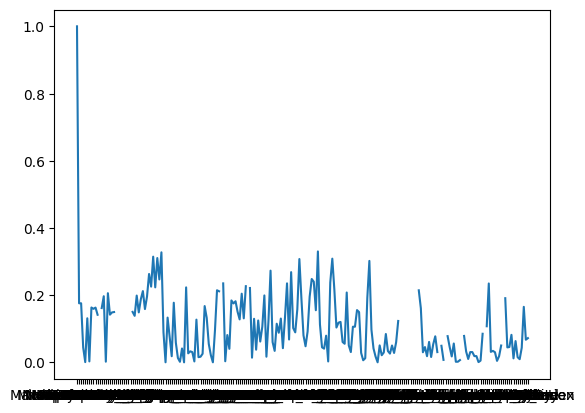

In [15]:
plt.plot(abs(data.corr()["FFV"]))

In [16]:
cor

FFV                  1.000000
MaxAbsEStateIndex    0.175998
MaxEStateIndex       0.175999
MinAbsEStateIndex    0.044497
MinEStateIndex       0.000986
                       ...   
NPR1                 0.009673
NPR2                 0.043748
PMI1                 0.165439
PMI2                 0.067589
PMI3                 0.072331
Name: FFV, Length: 220, dtype: float64

### XGBOOST Regressor

In [17]:
final = data[cor[cor>0.2].index]
#final = data.copy()

In [18]:
#final["SMILES"] = data["SMILES"]

In [19]:
final.columns

Index(['FFV', 'MinAbsPartialCharge', 'Chi0v', 'Chi1v', 'Chi2n', 'Chi2v',
       'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'PEOE_VSA14', 'SMR_VSA6',
       'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA6', 'SlogP_VSA8', 'TPSA',
       'EState_VSA8', 'VSA_EState6', 'VSA_EState8', 'NHOHCount',
       'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHDonors',
       'RingCount', 'MolLogP', 'MolMR', 'fr_Ar_N', 'fr_NH1', 'fr_ester',
       'fr_quatN'],
      dtype='object')

In [20]:
final.shape

(6823, 31)

In [21]:
#final.drop('SMILES', axis=1,inplace=True)

In [22]:
final.isin([np.inf, -np.inf]).sum().values

array([ 0, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int64)

In [24]:
final.replace([np.inf, -np.inf], np.nan, inplace=True)
final.fillna(final.mean(), inplace=True) 

C:\Users\shasa\AppData\Local\Temp\ipykernel_1648\666826105.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\shasa\AppData\Local\Temp\ipykernel_1648\666826105.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final.fillna(final.mean(), inplace=True)


In [26]:
final.to_csv("FFV_checkpoint.csv",index=False)

In [28]:
scaler = MinMaxScaler() #scaling
final_scale = pd.DataFrame(scaler.fit_transform(final.drop('FFV', axis=1)),columns=final.columns.to_list()[1:])

In [29]:
X = final_scale
y = final['FFV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)  
y_pred_test = model.predict(X_test)   

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("Training Performance:")
print(f"RMSE: {rmse_train:.4f}")
print(f"R²: {r2_train:.4f}\n")
print("Test Performance:")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")

Training Performance:
RMSE: 0.0041
R²: 0.9805

Test Performance:
RMSE: 0.0135
R²: 0.8032


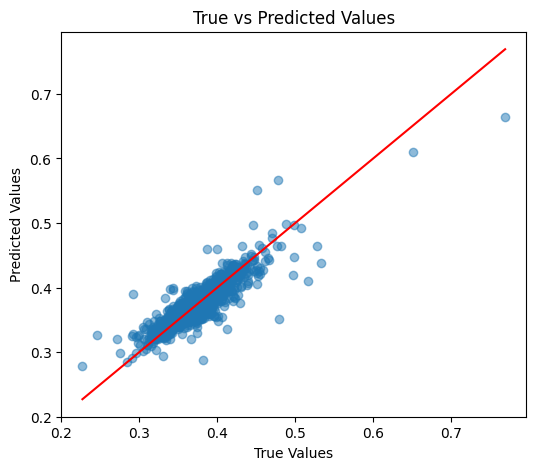

In [31]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

In [32]:
idx = model.feature_importances_.argsort()

<BarContainer object of 10 artists>

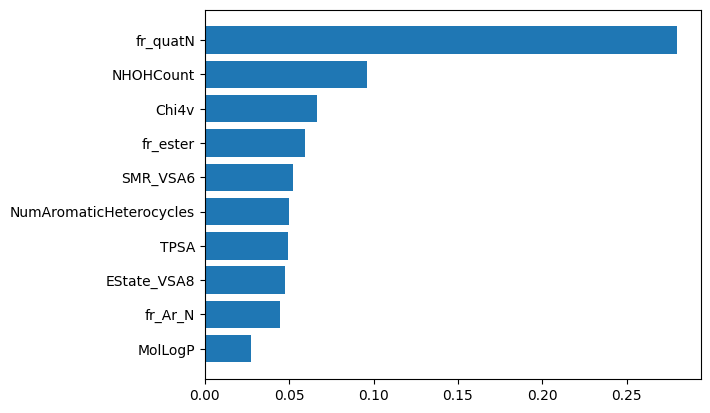

In [33]:
plt.barh(X_train.columns[idx][20:30],model.feature_importances_[idx][20:30])

## NN - Fingerprint

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [35]:
def elastic_net_loss(output, target, model, l1_lambda, l2_lambda):
    mse_loss = nn.MSELoss()(output, target)  
    
    l1_penalty = sum(p.abs().sum() for p in model.parameters())  
    l2_penalty = sum((p ** 2).sum() for p in model.parameters()) 
    
    return mse_loss + l1_lambda * l1_penalty + l2_lambda * l2_penalty

In [36]:
class NNRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3,hidden_dim4, dropout_rate):
        super(NNRegressor, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3) 
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4) 
        self.fc5 = nn.Linear(hidden_dim4, 1)
        
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc5(x)
        return x 

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

class NNDataset(Dataset):
    def __init__(self, df, label_column):
        self.embeddings = torch.tensor(df.drop(columns=[label_column]).values, dtype=torch.float32)
        self.labels = torch.tensor(df[label_column].values, dtype=torch.float32).unsqueeze(1) 

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [37]:
def train_model(model, data_loader, optimizer, l1_lambda, l2_lambda, epochs):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in data_loader:
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Compute elastic net loss
            loss = elastic_net_loss(outputs, targets, model, l1_lambda, l2_lambda)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(data_loader):.4f}")

In [38]:
def evaluate_model(model, data_loader, l1_lambda, l2_lambda):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            
            mse_loss = nn.MSELoss()(outputs, labels)

            l1_penalty = sum(p.abs().sum() for p in model.parameters())
            l2_penalty = sum((p ** 2).sum() for p in model.parameters())

            loss = mse_loss + l1_lambda * l1_penalty + l2_lambda * l2_penalty
            total_loss += loss.item()

            all_preds.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
    print(f"Test RMSE Loss: {rmse:.4f}")

    r2_test = r2_score(all_labels, all_preds)
    print(f"Test R²: {r2_test:.4f}")

    plt.figure(figsize=(6, 5))
    plt.scatter(all_labels, all_preds, alpha=0.5)
    plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("True vs Predicted Values")
    plt.show()

In [39]:
import pandas as pd

In [40]:
datafile = pd.read_csv("train.csv")

In [41]:
datafile.shape

(7973, 7)

In [42]:
data=datafile.copy()

In [43]:
#Rg
datafile = data[['SMILES','FFV']]
datafile.dropna(inplace=True)

C:\Users\shasa\AppData\Local\Temp\ipykernel_1648\2442577831.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafile.dropna(inplace=True)


In [44]:
datafile.shape

(7030, 2)

In [45]:
smiles_list = datafile["SMILES"].to_list()
activity_values = datafile["FFV"].to_list()

In [46]:
def smiles_to_fingerprint(smiles, radius=1, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [47]:
fingerprints = np.array([smiles_to_fingerprint(s) for s in smiles_list if smiles_to_fingerprint(s) is not None])

[00:44:45] DEPRECATION WARNING: please use MorganGenerator
[00:44:45] DEPRECATION WARNING: please use MorganGenerator
[00:44:45] DEPRECATION WARNING: please use MorganGenerator
[00:44:45] DEPRECATION WARNING: please use MorganGenerator
[00:44:45] DEPRECATION WARNING: please use MorganGenerator
[00:44:45] DEPRECATION WARNING: please use MorganGenerator
[00:44:45] DEPRECATION WARNING: please use MorganGenerator
[00:44:45] DEPRECATION WARNING: please use MorganGenerator
[00:44:45] DEPRECATION WARNING: please use MorganGenerator
[00:44:45] DEPRECATION WARNING: please use MorganGenerator
[00:44:45] DEPRECATION WARNING: please use MorganGenerator
[00:44:45] DEPRECATION WARNING: please use MorganGenerator
[00:44:45] DEPRECATION WARNING: please use MorganGenerator
[00:44:45] DEPRECATION WARNING: please use MorganGenerator
[00:44:45] DEPRECATION WARNING: please use MorganGenerator
[00:44:45] DEPRECATION WARNING: please use MorganGenerator
[00:44:45] DEPRECATION WARNING: please use MorganGenerat

In [48]:
datafile.reset_index(drop=True,inplace=True)

In [49]:
final2 = pd.concat([datafile,pd.DataFrame(fingerprints)],axis=1).drop("SMILES",axis=1)

In [50]:
final2

FFV  0  1  2  3  4  5  6  7  8  ...  2038  2039  2040  2041  2042  \
0     0.374645  0  1  0  0  0  0  0  0  0  ...     0     0     0     0     0   
1     0.370410  0  1  0  0  0  0  0  0  0  ...     0     0     0     0     0   
2     0.378860  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0   
3     0.387324  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0   
4     0.355470  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0   
...        ... .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   
7025  0.385608  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0   
7026  0.367498  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0   
7027  0.353280  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0   
7028  0.369411  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0   
7029  0.374049  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0   

      2043  2044  2045  2046  2047  
0        0     0     0     0     0  
1        0     0     0     0     0  
2        0     0     0     0     0  
3        0     0     0     0     0  
4        0     0     0     0     0  
...    ...   ...   ...   ...   ...  
7025     0     0     0     0     0  
7026     0     0     0     0     0  
7027     0     0     0     0     0  
7028     0     0     0     0     0  
7029     0     0     0     0     0  

[7030 rows x 2049 columns]

In [51]:
input_dim = 2048
hidden_dim1 = 2048*2
hidden_dim2 = 1024*3
hidden_dim3 = 1024
hidden_dim4 = 50
dropout_rate = 0.1
epochs = 100

model = NNRegressor(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, dropout_rate)
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

l1_lambda = 0
l2_lambda = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

label_column = "FFV"
train_df, test_df = train_test_split(final2, test_size=0.3, random_state=42)

train_dataset = NNDataset(train_df, label_column)
train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)

test_dataset = NNDataset(test_df, label_column)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=True)

best_loss = float("inf")
best_model_state = None

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        l1_reg = sum(p.abs().sum() for p in model.parameters())
        loss = criterion(outputs, targets) + l1_lambda * l1_reg

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    #best model
    if avg_train_loss < best_loss:
        best_loss = avg_train_loss
        best_model_state = model.state_dict()

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

model.load_state_dict(best_model_state)
print(f"Best model loaded with Train Loss: {best_loss:.4f}")

Epoch 1/100, Train Loss: 0.3093
Epoch 2/100, Train Loss: 0.1105
Epoch 3/100, Train Loss: 0.0766
Epoch 4/100, Train Loss: 0.0619
Epoch 5/100, Train Loss: 0.0527
Epoch 6/100, Train Loss: 0.0493
Epoch 7/100, Train Loss: 0.0463
Epoch 8/100, Train Loss: 0.0442
Epoch 9/100, Train Loss: 0.0429
Epoch 10/100, Train Loss: 0.0417
Epoch 11/100, Train Loss: 0.0410
Epoch 12/100, Train Loss: 0.0402
Epoch 13/100, Train Loss: 0.0394
Epoch 14/100, Train Loss: 0.0389
Epoch 15/100, Train Loss: 0.0387
Epoch 16/100, Train Loss: 0.0379
Epoch 17/100, Train Loss: 0.0367
Epoch 18/100, Train Loss: 0.0365
Epoch 19/100, Train Loss: 0.0351
Epoch 20/100, Train Loss: 0.0351
Epoch 21/100, Train Loss: 0.0349
Epoch 22/100, Train Loss: 0.0345
Epoch 23/100, Train Loss: 0.0338
Epoch 24/100, Train Loss: 0.0330
Epoch 25/100, Train Loss: 0.0344
Epoch 26/100, Train Loss: 0.0339
Epoch 27/100, Train Loss: 0.0341
Epoch 28/100, Train Loss: 0.0337
Epoch 29/100, Train Loss: 0.0337
Epoch 30/100, Train Loss: 0.0336
Epoch 31/100, Train

Test RMSE Loss: 0.0178
Test R²: 0.6663


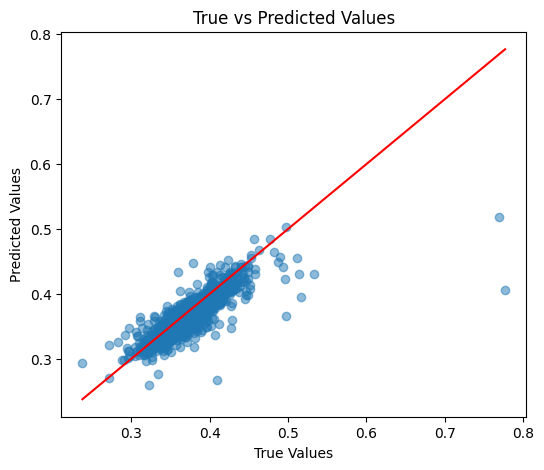

In [52]:
evaluate_model(model, test_loader, l1_lambda, l2_lambda)